In [1]:
# Import 
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


torch.cuda.empty_cache()

# Get CUDA
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Define Hotdog data class
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y



# Load data
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
train_transform1 = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.RandomRotation(degrees=50),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 16
trainset = Hotdog_NotHotdog(train=True, transform=train_transform1)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target)  #torch.log()
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(      
            nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, padding=1, stride=1))
        
    def forward(self, x):
        Fx = self.block(x)
        out = Fx + x 
        out = F.relu(out)
        return out




class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.BatchNorm2d(n_features),  
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
            conv_layers.append(nn.BatchNorm2d(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        
        self.fc = nn.Sequential(
                                
                                nn.Linear(size*size*n_features, 2048*2),
                                nn.BatchNorm1d(2048*2),
                                nn.ReLU(),
                                nn.Dropout(0.5),

                                nn.Linear(2048*2, 512*2),
                                nn.BatchNorm1d(512*2),
                                nn.ReLU(),
                                nn.Dropout(0.5),

                                nn.Linear(512*2, 512),
                                nn.BatchNorm1d(512),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                
                                nn.Linear(512,2))

        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out #F.log_softmax(out, dim=1)


model = ResNet(n_in=3, n_features=16, num_res_blocks=4)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)#lr=0.001
out_dict = train(model, optimizer)

The code will run on GPU.


 50%|█████████████████████████████████████████                                         | 64/128 [00:10<00:10,  6.11it/s]


 10%|████████                                                                         | 1/10 [00:23<03:29, 23.25s/epoch]

Loss train: 0.696	 test: 0.617	 Accuracy train: 57.7%	 test: 67.6%



 51%|█████████████████████████████████████████▋                                        | 65/128 [00:10<00:10,  6.12it/s]


 20%|████████████████▏                                                                | 2/10 [00:46<03:05, 23.25s/epoch]

Loss train: 0.651	 test: 0.602	 Accuracy train: 63.4%	 test: 68.4%



 51%|█████████████████████████████████████████▋                                        | 65/128 [00:10<00:10,  6.11it/s]


 30%|████████████████████████▎                                                        | 3/10 [01:09<02:43, 23.30s/epoch]

Loss train: 0.622	 test: 0.580	 Accuracy train: 66.9%	 test: 71.2%



 51%|█████████████████████████████████████████▋                                        | 65/128 [00:10<00:10,  6.10it/s]


 40%|████████████████████████████████▍                                                | 4/10 [01:33<02:19, 23.31s/epoch]

Loss train: 0.600	 test: 0.574	 Accuracy train: 68.1%	 test: 72.0%



 51%|█████████████████████████████████████████▋                                        | 65/128 [00:10<00:10,  6.11it/s]


 50%|████████████████████████████████████████▌                                        | 5/10 [01:56<01:56, 23.31s/epoch]

Loss train: 0.589	 test: 0.565	 Accuracy train: 68.7%	 test: 72.5%



 51%|█████████████████████████████████████████▋                                        | 65/128 [00:10<00:10,  6.11it/s]


 60%|████████████████████████████████████████████████▌                                | 6/10 [02:19<01:33, 23.30s/epoch]

Loss train: 0.568	 test: 0.560	 Accuracy train: 72.0%	 test: 73.7%



 51%|█████████████████████████████████████████▋                                        | 65/128 [00:10<00:10,  6.11it/s]


 70%|████████████████████████████████████████████████████████▋                        | 7/10 [02:43<01:09, 23.29s/epoch]

Loss train: 0.568	 test: 0.548	 Accuracy train: 71.2%	 test: 74.0%



 51%|█████████████████████████████████████████▋                                        | 65/128 [00:10<00:10,  6.12it/s]


 80%|████████████████████████████████████████████████████████████████▊                | 8/10 [03:06<00:46, 23.26s/epoch]

Loss train: 0.548	 test: 0.543	 Accuracy train: 72.7%	 test: 74.2%



 51%|█████████████████████████████████████████▋                                        | 65/128 [00:10<00:10,  6.11it/s]


 90%|████████████████████████████████████████████████████████████████████████▉        | 9/10 [03:29<00:23, 23.27s/epoch]

Loss train: 0.541	 test: 0.541	 Accuracy train: 73.8%	 test: 74.5%



 51%|█████████████████████████████████████████▋                                        | 65/128 [00:10<00:10,  6.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [03:52<00:00, 23.29s/epoch]

Loss train: 0.540	 test: 0.544	 Accuracy train: 73.2%	 test: 74.0%


In [7]:
out_dict['train_acc']

[0.6575476306790425,
 0.706399609184172,
 0.7445041524181729,
 0.7655105031753786,
 0.769418661455789,
 0.7860283341475329,
 0.7855398143624817,
 0.8045920859794822,
 0.8148510014655593,
 0.8128969223253542]

In [3]:
# lr=0.01, 73.6%
# lr = 0.001,76.9%, 78.1%
# lr = 0.0001, 76.9%

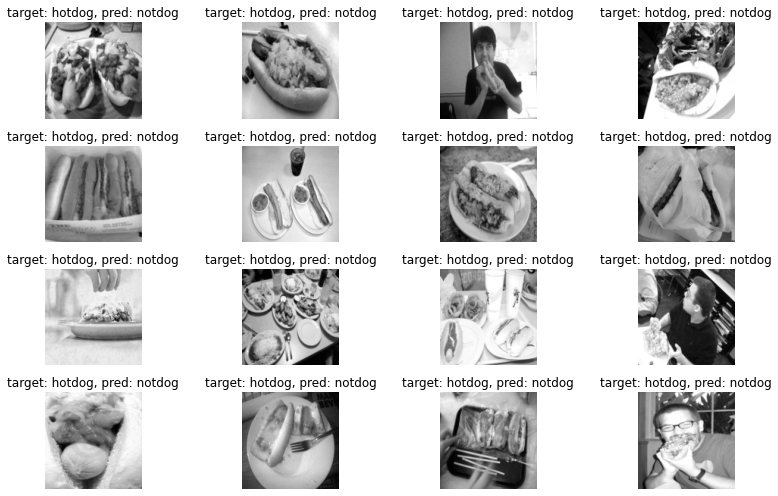

In [11]:
# Saliency for same images
test_count = 0
fig, axs = plt.subplots(4,4,figsize=(12,7), gridspec_kw={'height_ratios': [1, 1,1,1]})

for data, target in test_loader:
    data = data.to(device)
    data.requires_grad_()
    output = model(data)
    predicted = output.argmax(1).cpu()
    
    # Catch the output
    output_idx = output.argmax(dim=1)

    for i in range(len(target)-2):
        if target[i]!=predicted[i]:
            axs.flatten()[test_count].imshow(data[i].detach().cpu().numpy()[0], 'gray')
            axs.flatten()[test_count].set_title(f'target: {"hotdog" if target[i].item() == 0 else "notdog"}, pred: {"hotdog" if predicted[i].item() == 0 else "notdog"}')
            axs.flatten()[test_count].axis('off')

            
            test_count += 1
    
        if test_count == 16:
            break;
    if test_count == 16:
        break;


#plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, hspace=0.2, wspace=0.02)
plt.tight_layout()
#plt.savefig('saliency.png')